In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option('max_columns',90)
pd.set_option('max_rows',None)
import statsmodels.api as sm
from scipy.stats import binom
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

In [2]:
filename = 'Medicare_Physician_and_Other_Supplier_NPI_Aggregate_CY2014.txt'
data = pd.read_csv(filename,sep='\t')
dataI = data[data.nppes_entity_code=='I']
ultrascores = pd.read_csv('ultrascores.csv')
neph = ultrascores.merge(dataI)

C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
neph.head()

,npi,ultra_score,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,nppes_provider_zip,nppes_provider_state,nppes_provider_country,provider_type,medicare_participation_indicator,number_of_hcpcs,total_services,total_unique_benes,total_submitted_chrg_amt,total_medicare_allowed_amt,total_medicare_payment_amt,total_medicare_stnd_amt,drug_suppress_indicator,number_of_drug_hcpcs,total_drug_services,total_drug_unique_benes,total_drug_submitted_chrg_amt,total_drug_medicare_allowed_amt,total_drug_medicare_payment_amt,total_drug_medicare_stnd_amt,med_suppress_indicator,number_of_med_hcpcs,total_med_services,total_med_unique_benes,total_med_submitted_chrg_amt,total_med_medicare_allowed_amt,total_med_medicare_payment_amt,total_med_medicare_stnd_amt,beneficiary_average_age,beneficiary_age_less_65_count,beneficiary_age_65_74_count,beneficiary_age_75_84_count,beneficiary_age_greater_84_count,beneficiary_female_count,beneficiary_male_count,beneficiary_race_white_count,beneficiary_race_black_count,beneficiary_race_api_count,beneficiary_race_hispanic_count,beneficiary_race_natind_count,beneficiary_race_other_count,beneficiary_nondual_count,beneficiary_dual_count,beneficiary_cc_afib_percent,beneficiary_cc_alzrdsd_percent,beneficiary_cc_asthma_percent,beneficiary_cc_cancer_percent,beneficiary_cc_chf_percent,beneficiary_cc_ckd_percent,beneficiary_cc_copd_percent,beneficiary_cc_depr_percent,beneficiary_cc_diab_percent,beneficiary_cc_hyperl_percent,beneficiary_cc_hypert_percent,beneficiary_cc_ihd_percent,beneficiary_cc_ost_percent,beneficiary_cc_raoa_percent,beneficiary_cc_schiot_percent,beneficiary_cc_strk_percent,Beneficiary_Average_Risk_Score
0,1003003609,304.9,PAKKIVENKATA,UMA,B,M.D.,M,I,9900 N CENTRAL EXPY STE 215,NaN,DALLAS,752310929,TX,US,Nephrology,Y,21,3597.0,582,834778.00,417036.56,325817.95,326986.74,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,21.0,3597.0,582.0,834778.00,417036.56,325817.95,326986.74,72,131.0,192.0,173.0,86.0,326.0,256.0,362.0,134.0,NaN,65.0,NaN,NaN,314.0,268.0,24.0,40.0,18.0,11.0,66.0,75.0,39.0,44.0,68.0,73.0,75.0,66.0,9.0,51.0,9.0,20.0,3.2725
1,1003016775,319.0,DIAZ,ANTONIO,L,MD,M,I,7000 CARR 844 # 844,BOX 143,SAN JUAN,9269570,PR,US,Nephrology,Y,11,694.0,131,109613.37,104724.32,80036.72,86654.65,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,11.0,694.0,131.0,109613.37,104724.32,80036.72,86654.65,70,44.0,26.0,38.0,23.0,51.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,28.0,11.0,13.0,60.0,75.0,11.0,18.0,75.0,49.0,75.0,63.0,NaN,34.0,NaN,16.0,4.5405
2,1003019647,337.0,MULAMALLA,SUMANTH,NaN,MD,M,I,15900 W 101ST AVE,NaN,DYER,463113065,IN,US,Nephrology,Y,21,2615.0,521,454906.00,232055.25,180751.40,183126.72,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,21.0,2615.0,521.0,454906.00,232055.25,180751.40,183126.72,72,122.0,155.0,153.0,91.0,274.0,247.0,213.0,251.0,NaN,NaN,NaN,NaN,280.0,241.0,32.0,41.0,17.0,14.0,75.0,75.0,51.0,31.0,71.0,68.0,75.0,75.0,11.0,61.0,15.0,24.0,4.7312
3,1003023581,350.0,HINGORANI,JAIDEEP,NaN,NaN,M,I,3300 TAMIAMI TRL,#101A,PORT CHARLOTTE,339528054,FL,US,Neurology,Y,15,3138.0,746,412988.45,353156.86,269459.30,268033.46,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,15.0,3138.0,746.0,412988.45,353156.86,269459.30,268033.46,74,101.0,240.0,266.0,139.0,314.0,432.0,633.0,55.0,NaN,42.0,0.0,NaN,572.0,174.0,26.0,21.0,9.0,15.0,51.0,75.0,37.0,29.0,55.0,75.0,75.0,70.0,10.0,42.0,9.0,8.0,3.0545
4,1003042490,325.0,BANERJEE,TRINA,D,M.D.,F,I,730 N BROAD ST,101,WOODBURY,80961796,NJ,US,Nephrology,Y,18,2468.0,421,318125.98,213108.85,164172.04,144577.99,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,18.0,2468.0,421.0,318125.98,213108.85,164172.04,144577.99,72,101.0,131.0,111.0,78.0,227.0,194.0,305.0,99.0,NaN,NaN,NaN,NaN,292.0,129.0,25.0,29.0,14.0,14.0,60.0,75.0,37.0,30.0,65.0,68.0,75.0,69.0,5.0,42.0,5.0,13.0,4.0852


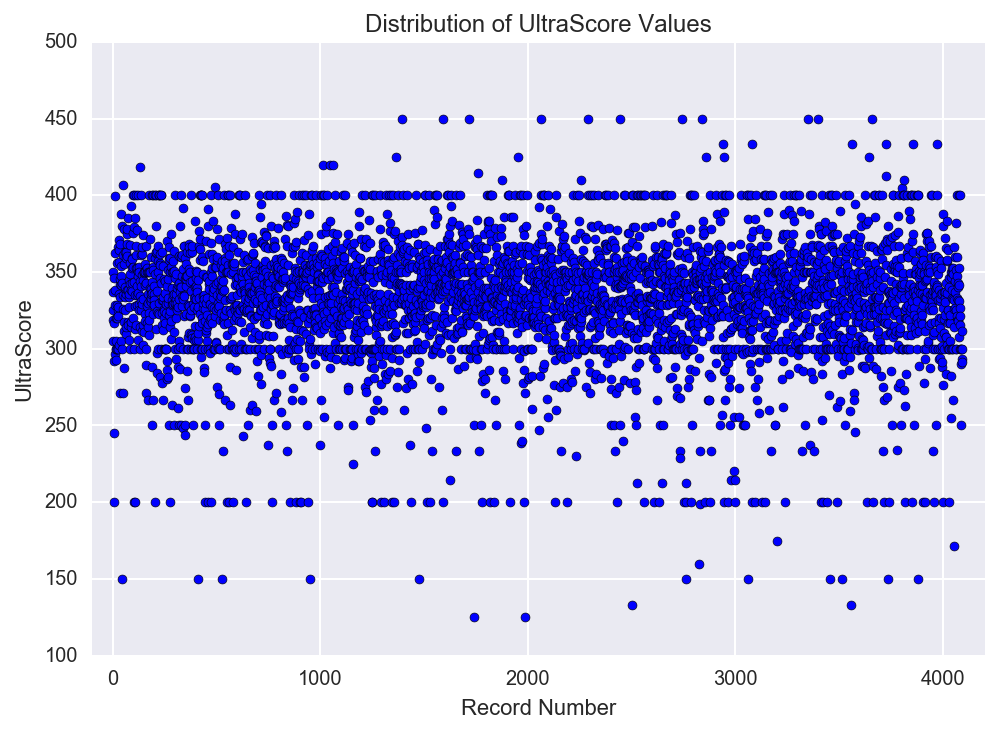

In [4]:
plt.scatter(np.arange(len(neph)),neph.ultra_score)
plt.xlabel('Record Number')
plt.ylabel('UltraScore')
plt.axis([-100,4200,100,500])
plt.title('Distribution of UltraScore Values')
plt.show()

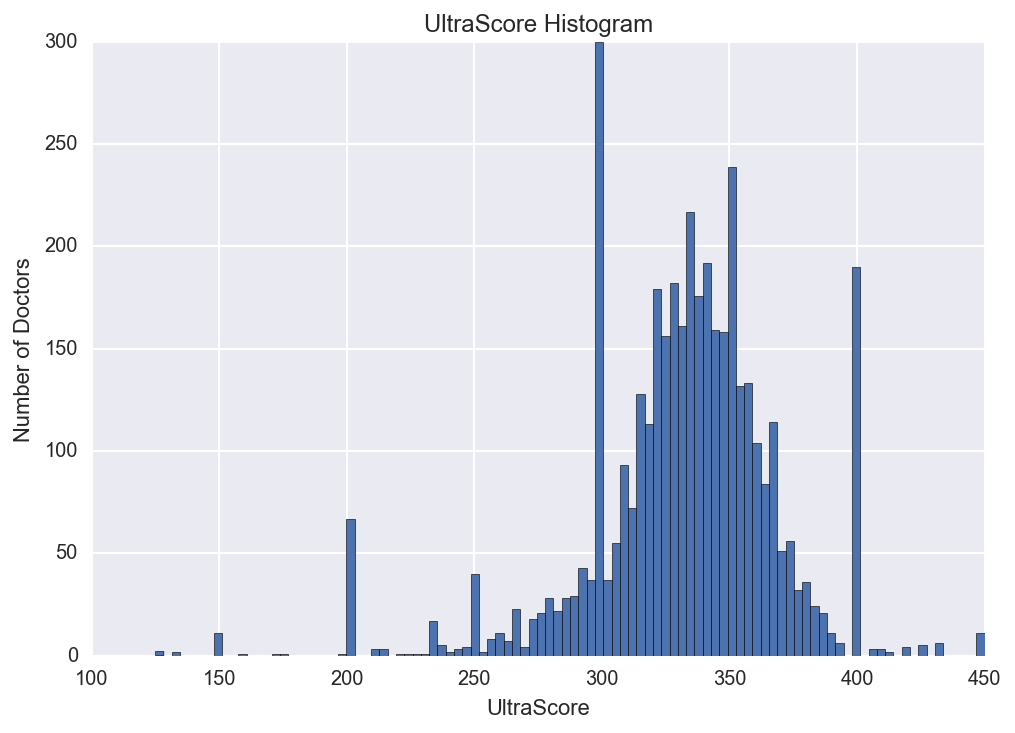

In [5]:
plt.hist(neph.ultra_score,bins=100)
plt.xlabel('UltraScore')
plt.ylabel('Number of Doctors')
plt.title('UltraScore Histogram')
plt.show()

In [6]:
# Evidently the ultrascore process is favoring round numbers. See the huge spikes at ultrascore = 200, 300, and 400.

In [7]:
nNeph = neph.select_dtypes(exclude=['object'])

In [8]:
nCorr = nNeph[nNeph.columns[1:]].corr()  # removes npi

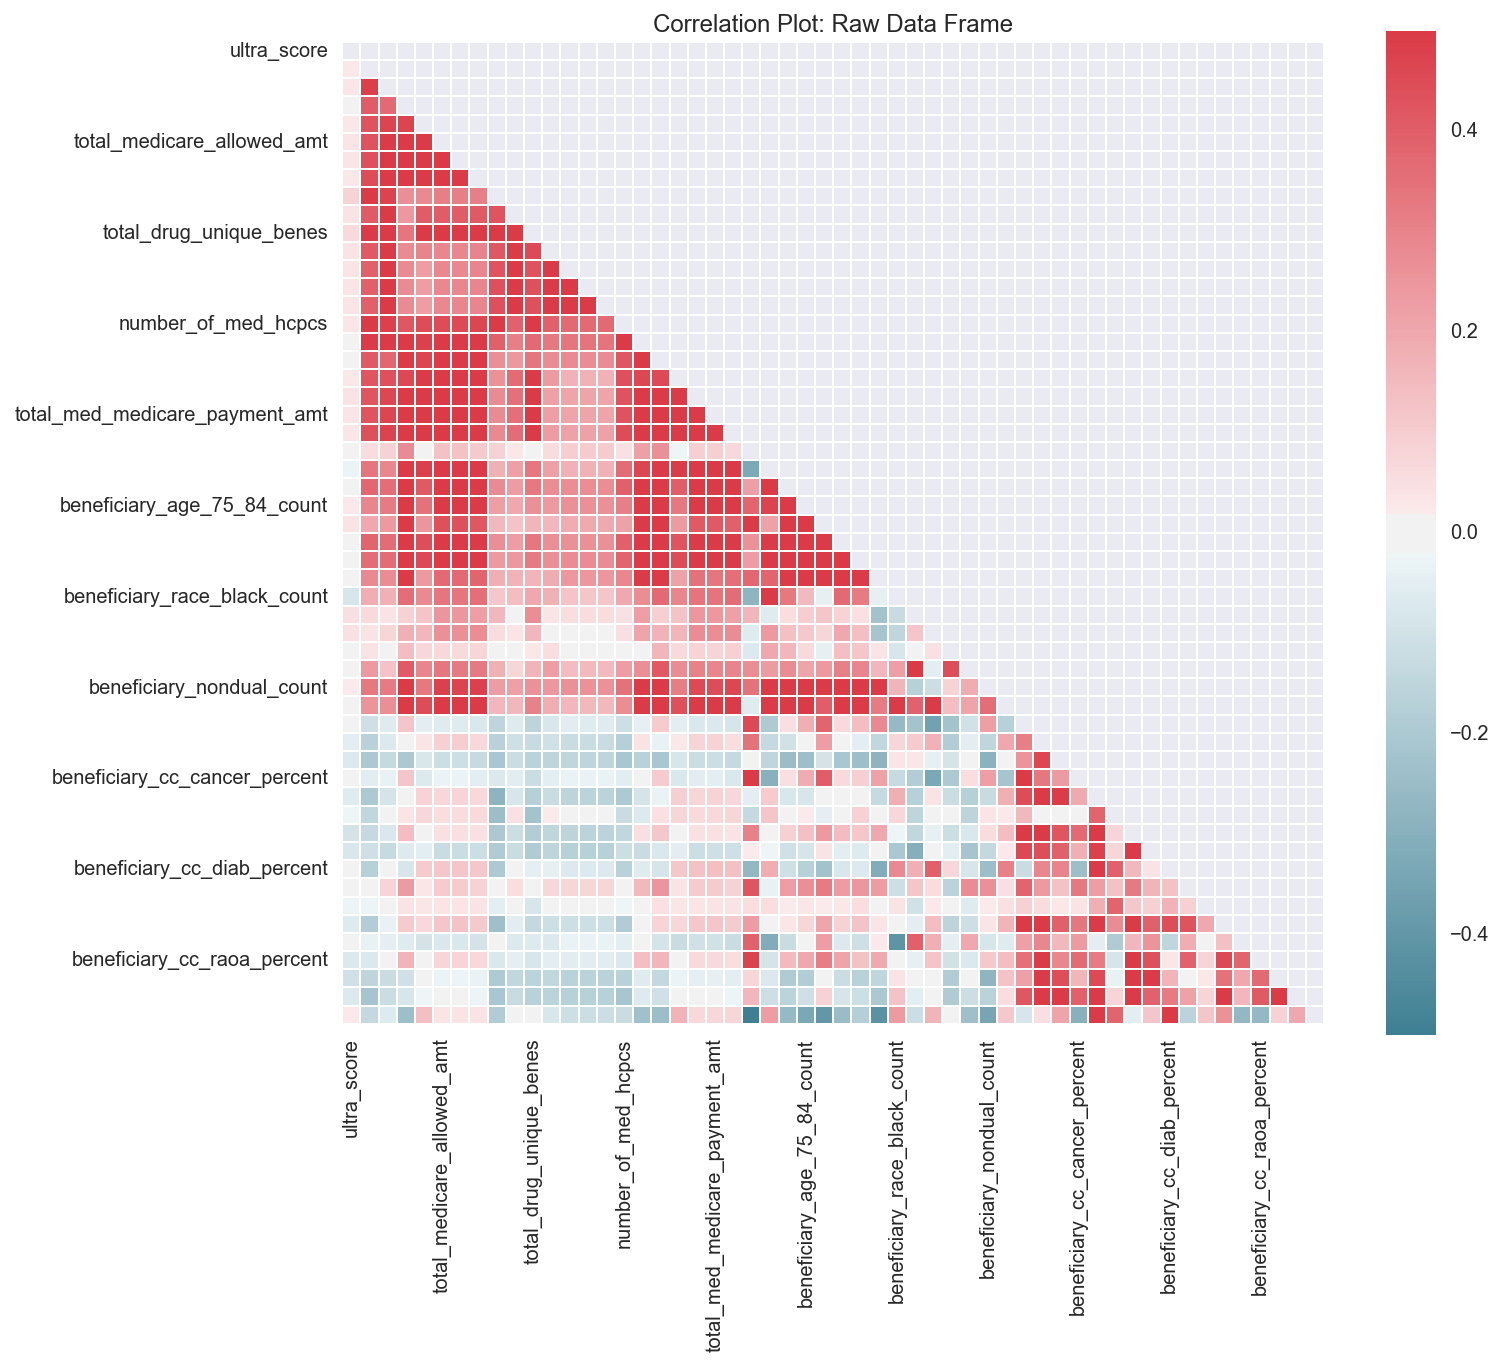

In [9]:
mask = np.zeros_like(nCorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(nCorr, mask=mask, cmap=cmap, vmin=-0.5, vmax=.5,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, ax=ax)
plt.title('Correlation Plot: Raw Data Frame')
plt.show()

In [10]:
# Many of our features are strongly correlated with the volume of business conducted by each doctor.
    # Hence the big red block in the upper left.
# Let's divide out the accumulation variables to get a better idea what's going on:
    # Express the patient demographic counts as percentages
    # Express payment variables as per patient, and Medicare-allowed-amounts as fractions of the whole

In [11]:
pNeph = neph.select_dtypes(exclude=['object'])

# re-define the demographic columns to be percentages, rather than raw counts:
cols_pctof_TotUniBen = ['beneficiary_age_less_65_count','beneficiary_age_65_74_count',
                        'beneficiary_age_75_84_count','beneficiary_age_greater_84_count',
                        'beneficiary_female_count','beneficiary_male_count','beneficiary_race_white_count',
                        'beneficiary_race_black_count','beneficiary_race_api_count','beneficiary_race_hispanic_count',
                        'beneficiary_race_natind_count','beneficiary_race_other_count',
                        'beneficiary_nondual_count','beneficiary_dual_count']
colNameReplacements_dict = {x:x.replace('_count','_pct') for x in cols_pctof_TotUniBen}
for cc in cols_pctof_TotUniBen:
    pNeph[cc] = 100.0*pNeph[cc]/pNeph.total_unique_benes
pNeph.rename(columns=colNameReplacements_dict,inplace=True)

# also redefine the Medicare payment amounts as fractions rather than raw dollars:
pNeph.total_medicare_stnd_amt = pNeph.total_medicare_stnd_amt / pNeph.total_medicare_payment_amt
pNeph.total_drug_medicare_stnd_amt = pNeph.total_drug_medicare_stnd_amt / pNeph.total_drug_medicare_payment_amt
pNeph.total_med_medicare_stnd_amt = pNeph.total_med_medicare_stnd_amt / pNeph.total_med_medicare_payment_amt
pNeph.total_medicare_payment_amt = pNeph.total_medicare_payment_amt / pNeph.total_medicare_allowed_amt
pNeph.total_drug_medicare_payment_amt = pNeph.total_drug_medicare_payment_amt / pNeph.total_drug_medicare_allowed_amt
pNeph.total_med_medicare_payment_amt = pNeph.total_med_medicare_payment_amt / pNeph.total_med_medicare_allowed_amt
pNeph.total_medicare_allowed_amt = pNeph.total_medicare_allowed_amt / pNeph.total_submitted_chrg_amt
pNeph.total_drug_medicare_allowed_amt = pNeph.total_drug_medicare_allowed_amt / pNeph.total_drug_submitted_chrg_amt
pNeph.total_med_medicare_allowed_amt = pNeph.total_med_medicare_allowed_amt / pNeph.total_med_submitted_chrg_amt
# normalize total services and total submitted charges as the amount per beneficiary:
pNeph.total_submitted_chrg_amt = pNeph.total_submitted_chrg_amt/pNeph.total_unique_benes
pNeph.total_drug_submitted_chrg_amt = pNeph.total_drug_submitted_chrg_amt/pNeph.total_drug_unique_benes
pNeph.total_med_submitted_chrg_amt = pNeph.total_med_submitted_chrg_amt/pNeph.total_med_unique_benes
pNeph.total_services = pNeph.total_services/pNeph.total_unique_benes
pNeph.total_drug_services = pNeph.total_drug_services/pNeph.total_drug_unique_benes
pNeph.total_med_services = pNeph.total_med_services/pNeph.total_med_unique_benes
colNameReplacements_dict2 = {x:x.replace('_amt','_frac') for x in pNeph.columns}
pNeph.rename(columns=colNameReplacements_dict2,inplace=True)
colNameReplacements_dict3 = {'total_submitted_chrg_frac':'total_submitted_chrg_amt_per_bene',
                             'total_drug_submitted_chrg_frac':'total_drug_submitted_chrg_amt_per_drug_bene',
                             'total_med_submitted_chrg_frac':'total_med_submitted_chrg_amt_per_med_bene'}
pNeph.rename(columns=colNameReplacements_dict3,inplace=True)
colNameReplacements_dict4 = {'total_services':'total_services_per_bene',
                             'total_drug_services':'total_drug_services_per_drug_bene',
                             'total_med_services':'total_med_services_per_med_bene'}
pNeph.rename(columns=colNameReplacements_dict4,inplace=True)

C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\ipykernel\__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\pandas\core\frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\pandas\core\generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-co

In [12]:
nNeph.head()

,npi,ultra_score,number_of_hcpcs,total_services,total_unique_benes,total_submitted_chrg_amt,total_medicare_allowed_amt,total_medicare_payment_amt,total_medicare_stnd_amt,number_of_drug_hcpcs,total_drug_services,total_drug_unique_benes,total_drug_submitted_chrg_amt,total_drug_medicare_allowed_amt,total_drug_medicare_payment_amt,total_drug_medicare_stnd_amt,number_of_med_hcpcs,total_med_services,total_med_unique_benes,total_med_submitted_chrg_amt,total_med_medicare_allowed_amt,total_med_medicare_payment_amt,total_med_medicare_stnd_amt,beneficiary_average_age,beneficiary_age_less_65_count,beneficiary_age_65_74_count,beneficiary_age_75_84_count,beneficiary_age_greater_84_count,beneficiary_female_count,beneficiary_male_count,beneficiary_race_white_count,beneficiary_race_black_count,beneficiary_race_api_count,beneficiary_race_hispanic_count,beneficiary_race_natind_count,beneficiary_race_other_count,beneficiary_nondual_count,beneficiary_dual_count,beneficiary_cc_afib_percent,beneficiary_cc_alzrdsd_percent,beneficiary_cc_asthma_percent,beneficiary_cc_cancer_percent,beneficiary_cc_chf_percent,beneficiary_cc_ckd_percent,beneficiary_cc_copd_percent,beneficiary_cc_depr_percent,beneficiary_cc_diab_percent,beneficiary_cc_hyperl_percent,beneficiary_cc_hypert_percent,beneficiary_cc_ihd_percent,beneficiary_cc_ost_percent,beneficiary_cc_raoa_percent,beneficiary_cc_schiot_percent,beneficiary_cc_strk_percent,Beneficiary_Average_Risk_Score
0,1003003609,304.9,21,3597.0,582,834778.00,417036.56,325817.95,326986.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,3597.0,582.0,834778.00,417036.56,325817.95,326986.74,72,131.0,192.0,173.0,86.0,326.0,256.0,362.0,134.0,NaN,65.0,NaN,NaN,314.0,268.0,24.0,40.0,18.0,11.0,66.0,75.0,39.0,44.0,68.0,73.0,75.0,66.0,9.0,51.0,9.0,20.0,3.2725
1,1003016775,319.0,11,694.0,131,109613.37,104724.32,80036.72,86654.65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,694.0,131.0,109613.37,104724.32,80036.72,86654.65,70,44.0,26.0,38.0,23.0,51.0,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,28.0,11.0,13.0,60.0,75.0,11.0,18.0,75.0,49.0,75.0,63.0,NaN,34.0,NaN,16.0,4.5405
2,1003019647,337.0,21,2615.0,521,454906.00,232055.25,180751.40,183126.72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,2615.0,521.0,454906.00,232055.25,180751.40,183126.72,72,122.0,155.0,153.0,91.0,274.0,247.0,213.0,251.0,NaN,NaN,NaN,NaN,280.0,241.0,32.0,41.0,17.0,14.0,75.0,75.0,51.0,31.0,71.0,68.0,75.0,75.0,11.0,61.0,15.0,24.0,4.7312
3,1003023581,350.0,15,3138.0,746,412988.45,353156.86,269459.30,268033.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,3138.0,746.0,412988.45,353156.86,269459.30,268033.46,74,101.0,240.0,266.0,139.0,314.0,432.0,633.0,55.0,NaN,42.0,0.0,NaN,572.0,174.0,26.0,21.0,9.0,15.0,51.0,75.0,37.0,29.0,55.0,75.0,75.0,70.0,10.0,42.0,9.0,8.0,3.0545
4,1003042490,325.0,18,2468.0,421,318125.98,213108.85,164172.04,144577.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,2468.0,421.0,318125.98,213108.85,164172.04,144577.99,72,101.0,131.0,111.0,78.0,227.0,194.0,305.0,99.0,NaN,NaN,NaN,NaN,292.0,129.0,25.0,29.0,14.0,14.0,60.0,75.0,37.0,30.0,65.0,68.0,75.0,69.0,5.0,42.0,5.0,13.0,4.0852


In [13]:
pNeph.head()

,npi,ultra_score,number_of_hcpcs,total_services_per_bene,total_unique_benes,total_submitted_chrg_amt_per_bene,total_medicare_allowed_frac,total_medicare_payment_frac,total_medicare_stnd_frac,number_of_drug_hcpcs,total_drug_services_per_drug_bene,total_drug_unique_benes,total_drug_submitted_chrg_amt_per_drug_bene,total_drug_medicare_allowed_frac,total_drug_medicare_payment_frac,total_drug_medicare_stnd_frac,number_of_med_hcpcs,total_med_services_per_med_bene,total_med_unique_benes,total_med_submitted_chrg_amt_per_med_bene,total_med_medicare_allowed_frac,total_med_medicare_payment_frac,total_med_medicare_stnd_frac,beneficiary_average_age,beneficiary_age_less_65_pct,beneficiary_age_65_74_pct,beneficiary_age_75_84_pct,beneficiary_age_greater_84_pct,beneficiary_female_pct,beneficiary_male_pct,beneficiary_race_white_pct,beneficiary_race_black_pct,beneficiary_race_api_pct,beneficiary_race_hispanic_pct,beneficiary_race_natind_pct,beneficiary_race_other_pct,beneficiary_nondual_pct,beneficiary_dual_pct,beneficiary_cc_afib_percent,beneficiary_cc_alzrdsd_percent,beneficiary_cc_asthma_percent,beneficiary_cc_cancer_percent,beneficiary_cc_chf_percent,beneficiary_cc_ckd_percent,beneficiary_cc_copd_percent,beneficiary_cc_depr_percent,beneficiary_cc_diab_percent,beneficiary_cc_hyperl_percent,beneficiary_cc_hypert_percent,beneficiary_cc_ihd_percent,beneficiary_cc_ost_percent,beneficiary_cc_raoa_percent,beneficiary_cc_schiot_percent,beneficiary_cc_strk_percent,Beneficiary_Average_Risk_Score
0,1003003609,304.9,21,6.180412,582,1434.326460,0.499578,0.781270,1.003587,0.0,NaN,0.0,NaN,NaN,NaN,NaN,21.0,6.180412,582.0,1434.326460,0.499578,0.781270,1.003587,72,22.508591,32.989691,29.725086,14.776632,56.013746,43.986254,62.199313,23.024055,NaN,11.168385,NaN,NaN,53.951890,46.048110,24.0,40.0,18.0,11.0,66.0,75.0,39.0,44.0,68.0,73.0,75.0,66.0,9.0,51.0,9.0,20.0,3.2725
1,1003016775,319.0,11,5.297710,131,836.743282,0.955397,0.764261,1.082686,0.0,NaN,0.0,NaN,NaN,NaN,NaN,11.0,5.297710,131.0,836.743282,0.955397,0.764261,1.082686,70,33.587786,19.847328,29.007634,17.557252,38.931298,61.068702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,28.0,11.0,13.0,60.0,75.0,11.0,18.0,75.0,49.0,75.0,63.0,NaN,34.0,NaN,16.0,4.5405
2,1003019647,337.0,21,5.019194,521,873.140115,0.510117,0.778915,1.013141,0.0,NaN,0.0,NaN,NaN,NaN,NaN,21.0,5.019194,521.0,873.140115,0.510117,0.778915,1.013141,72,23.416507,29.750480,29.366603,17.466411,52.591171,47.408829,40.882917,48.176583,NaN,NaN,NaN,NaN,53.742802,46.257198,32.0,41.0,17.0,14.0,75.0,75.0,51.0,31.0,71.0,68.0,75.0,75.0,11.0,61.0,15.0,24.0,4.7312
3,1003023581,350.0,15,4.206434,746,553.603820,0.855125,0.763002,0.994709,0.0,NaN,0.0,NaN,NaN,NaN,NaN,15.0,4.206434,746.0,553.603820,0.855125,0.763002,0.994709,74,13.538874,32.171582,35.656836,18.632708,42.091153,57.908847,84.852547,7.372654,NaN,5.630027,0.0,NaN,76.675603,23.324397,26.0,21.0,9.0,15.0,51.0,75.0,37.0,29.0,55.0,75.0,75.0,70.0,10.0,42.0,9.0,8.0,3.0545
4,1003042490,325.0,18,5.862233,421,755.643658,0.669888,0.770367,0.880649,0.0,NaN,0.0,NaN,NaN,NaN,NaN,18.0,5.862233,421.0,755.643658,0.669888,0.770367,0.880649,72,23.990499,31.116390,26.365796,18.527316,53.919240,46.080760,72.446556,23.515439,NaN,NaN,NaN,NaN,69.358670,30.641330,25.0,29.0,14.0,14.0,60.0,75.0,37.0,30.0,65.0,68.0,75.0,69.0,5.0,42.0,5.0,13.0,4.0852


In [14]:
pCorr = pNeph[pNeph.columns[1:]].corr()  # removes npi

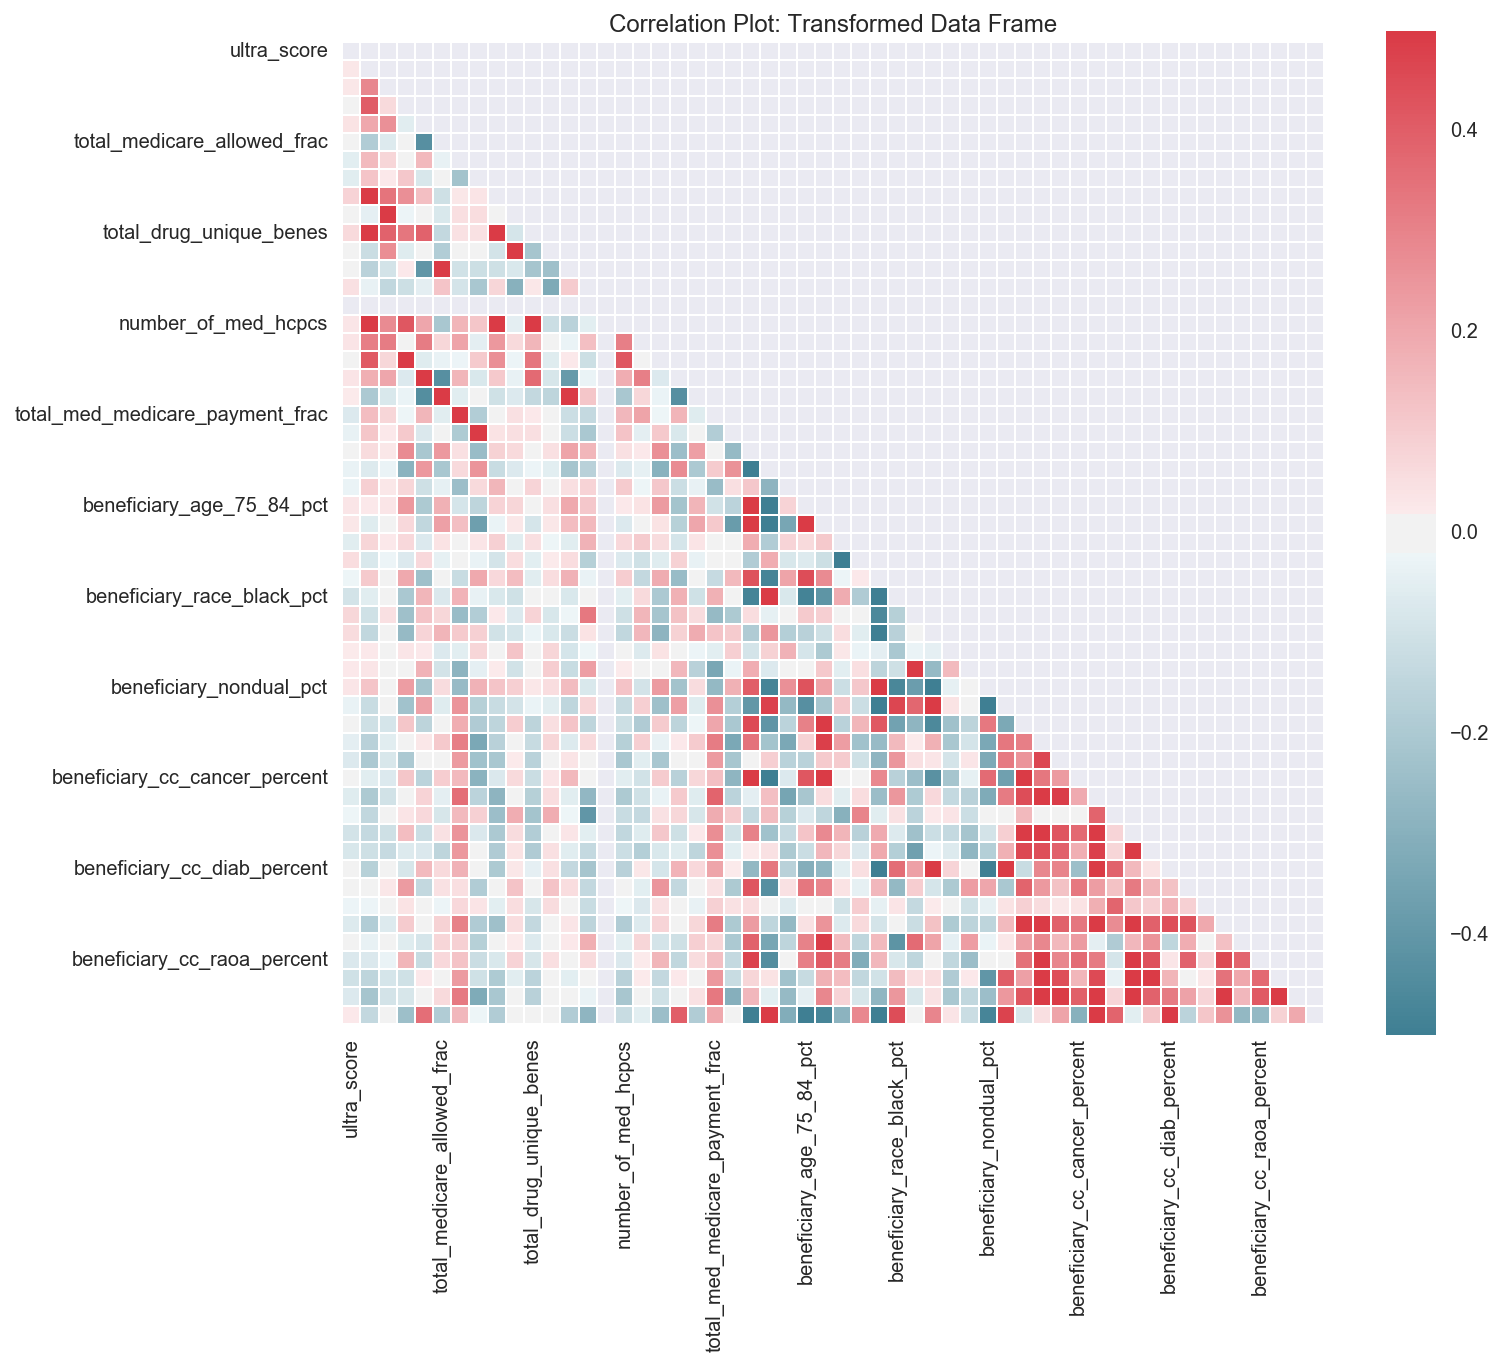

In [15]:
mask = np.zeros_like(pCorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(pCorr, mask=mask, cmap=cmap, vmin=-0.5, vmax=.5,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, ax=ax)
plt.title('Correlation Plot: Transformed Data Frame')

In [16]:
# There is a lot of missing data.
# For each field, print the number of rows missing that field:
for cc in nNeph:
    print('%d    %s' % (neph[cc].isnull().sum(),cc))

0    npi
0    ultra_score
0    number_of_hcpcs
0    total_services
0    total_unique_benes
0    total_submitted_chrg_amt
0    total_medicare_allowed_amt
0    total_medicare_payment_amt
0    total_medicare_stnd_amt
896    number_of_drug_hcpcs
896    total_drug_services
896    total_drug_unique_benes
896    total_drug_submitted_chrg_amt
896    total_drug_medicare_allowed_amt
896    total_drug_medicare_payment_amt
896    total_drug_medicare_stnd_amt
896    number_of_med_hcpcs
896    total_med_services
896    total_med_unique_benes
896    total_med_submitted_chrg_amt
896    total_med_medicare_allowed_amt
896    total_med_medicare_payment_amt
896    total_med_medicare_stnd_amt
0    beneficiary_average_age
115    beneficiary_age_less_65_count
109    beneficiary_age_65_74_count
273    beneficiary_age_75_84_count
269    beneficiary_age_greater_84_count
79    beneficiary_female_count
79    beneficiary_male_count
434    beneficiary_race_white_count
999    beneficiary_race_black_count
3194    ben

In [17]:
def xy_cdf(inArray):
    n = len(inArray)
    x = np.arange(inArray.min(),1+inArray.max())
    tempECDF = sm.distributions.ECDF(inArray)
    y = tempECDF(x)
    intervals = [binom.interval(0.95,n,yyy) for yyy in y]
    yLO = np.array([iii[0]/n for iii in intervals])
    yHI = np.array([iii[1]/n for iii in intervals])
    return (x,y,yLO,yHI)

In [18]:
# It might be instructive to see if the rows with missing data are representative of the whole.

# Below, it is shown that
    # the ultrascore distribution for the 896 doctors who have not classified their patients as drug or med patients
        # is indistinguishable from the distribution for the 3197 doctors who have
        
    # the ultrascore distribution for the 79 doctors who have not provided patient gender data
        # is somewhat higher than that for the 4016 doctors who did provide a gender split.
        # This difference is significant at the 95% level.


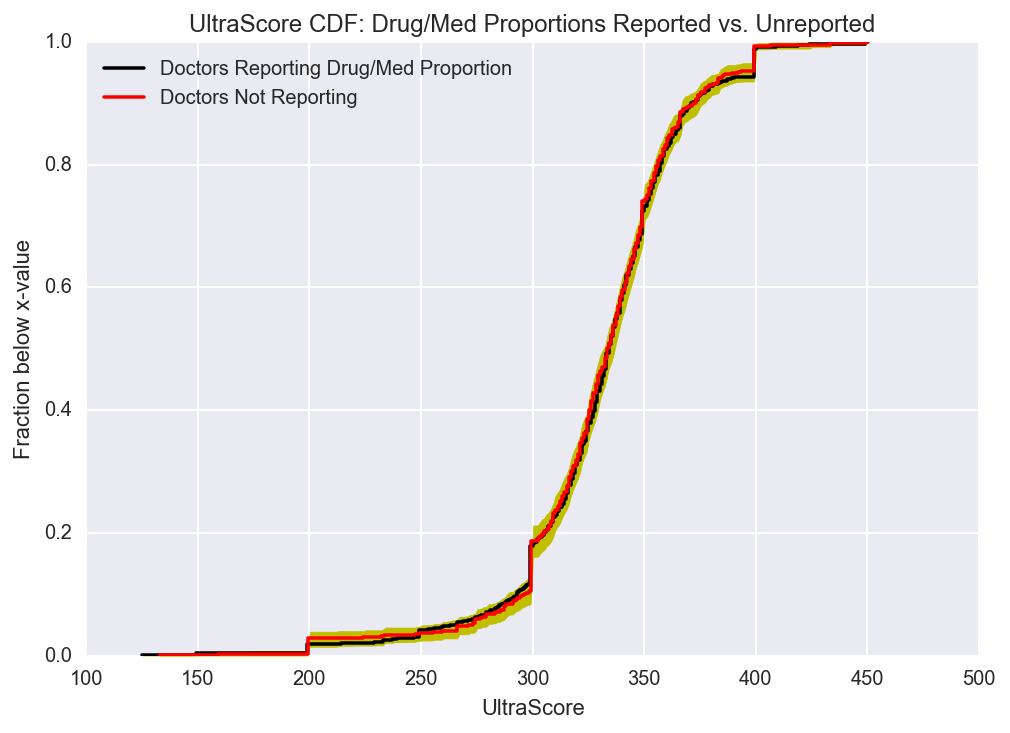

In [19]:
x1,y1,y1Lo,y1Hi = xy_cdf(neph.ultra_score[~neph.total_drug_services.isnull()])
x2,y2,y2Lo,y2Hi = xy_cdf(neph.ultra_score[neph.total_drug_services.isnull()])
kLine, = plt.step(x1,y1,color='k',label='Doctors Reporting Drug/Med Proportion')
rLine, = plt.step(x2,y2,color='r',label='Doctors Not Reporting')
plt.fill_between(x1,y1Lo,y1Hi,color='y')
plt.fill_between(x2,y2Lo,y2Hi,color='y')
plt.xlabel('UltraScore')
plt.ylabel('Fraction below x-value')
plt.title('UltraScore CDF: Drug/Med Proportions Reported vs. Unreported')
plt.legend(handles=[kLine,rLine],loc='upper left')
plt.show()

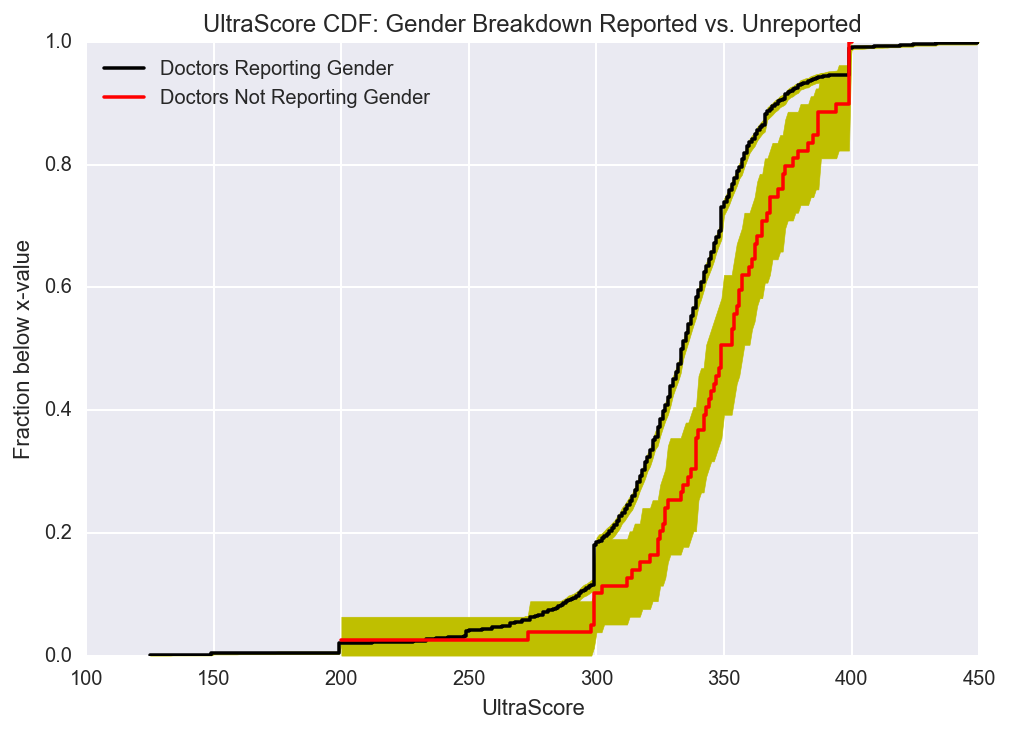

In [20]:
x1,y1,y1Lo,y1Hi = xy_cdf(neph.ultra_score[~neph.beneficiary_female_count.isnull()])
x2,y2,y2Lo,y2Hi = xy_cdf(neph.ultra_score[neph.beneficiary_female_count.isnull()])
kLine, = plt.step(x1,y1,color='k',label='Doctors Reporting Gender')
rLine, = plt.step(x2,y2,color='r',label='Doctors Not Reporting Gender')
plt.fill_between(x1,y1Lo,y1Hi,color='y')
plt.fill_between(x2,y2Lo,y2Hi,color='y')
plt.xlabel('UltraScore')
plt.ylabel('Fraction below x-value')
plt.title('UltraScore CDF: Gender Breakdown Reported vs. Unreported')
plt.legend(handles=[kLine,rLine],loc='upper left')
plt.show()

In [21]:
# Which factors correlate with ultrascore?

In [22]:
s_nUltraCorrs = nCorr.ultra_score.sort_values(inplace=False)
s_pUltraCorrs = pCorr.ultra_score.sort_values(inplace=False)

In [23]:
s_nUltraCorrs

beneficiary_cc_schiot_percent      -0.102697
beneficiary_cc_copd_percent        -0.097573
beneficiary_race_black_count       -0.082501
beneficiary_cc_depr_percent        -0.080435
beneficiary_cc_raoa_percent        -0.072538
beneficiary_cc_strk_percent        -0.070188
beneficiary_cc_asthma_percent      -0.069651
beneficiary_cc_ihd_percent         -0.065457
beneficiary_cc_chf_percent         -0.059242
beneficiary_cc_alzrdsd_percent     -0.050185
beneficiary_age_less_65_count      -0.029696
beneficiary_cc_hypert_percent      -0.023594
beneficiary_cc_ckd_percent         -0.020632
beneficiary_cc_afib_percent        -0.017803
beneficiary_cc_diab_percent        -0.015791
beneficiary_dual_count             -0.013707
beneficiary_cc_hyperl_percent      -0.011608
total_unique_benes                 -0.009087
beneficiary_cc_cancer_percent      -0.006215
total_med_unique_benes             -0.005351
beneficiary_female_count           -0.003733
beneficiary_age_65_74_count         0.000564
beneficiar

In [24]:
s_pUltraCorrs

beneficiary_cc_schiot_percent                 -0.102697
beneficiary_cc_copd_percent                   -0.097573
beneficiary_race_black_pct                    -0.096556
beneficiary_cc_depr_percent                   -0.080435
beneficiary_cc_raoa_percent                   -0.072538
beneficiary_cc_strk_percent                   -0.070188
beneficiary_cc_asthma_percent                 -0.069651
total_med_medicare_payment_frac               -0.069052
beneficiary_cc_ihd_percent                    -0.065457
beneficiary_cc_chf_percent                    -0.059242
beneficiary_female_pct                        -0.057705
total_medicare_stnd_frac                      -0.054900
total_medicare_payment_frac                   -0.053063
beneficiary_cc_alzrdsd_percent                -0.050185
total_med_medicare_stnd_frac                  -0.037892
beneficiary_age_less_65_pct                   -0.032176
beneficiary_dual_pct                          -0.032127
beneficiary_age_65_74_pct                     -0

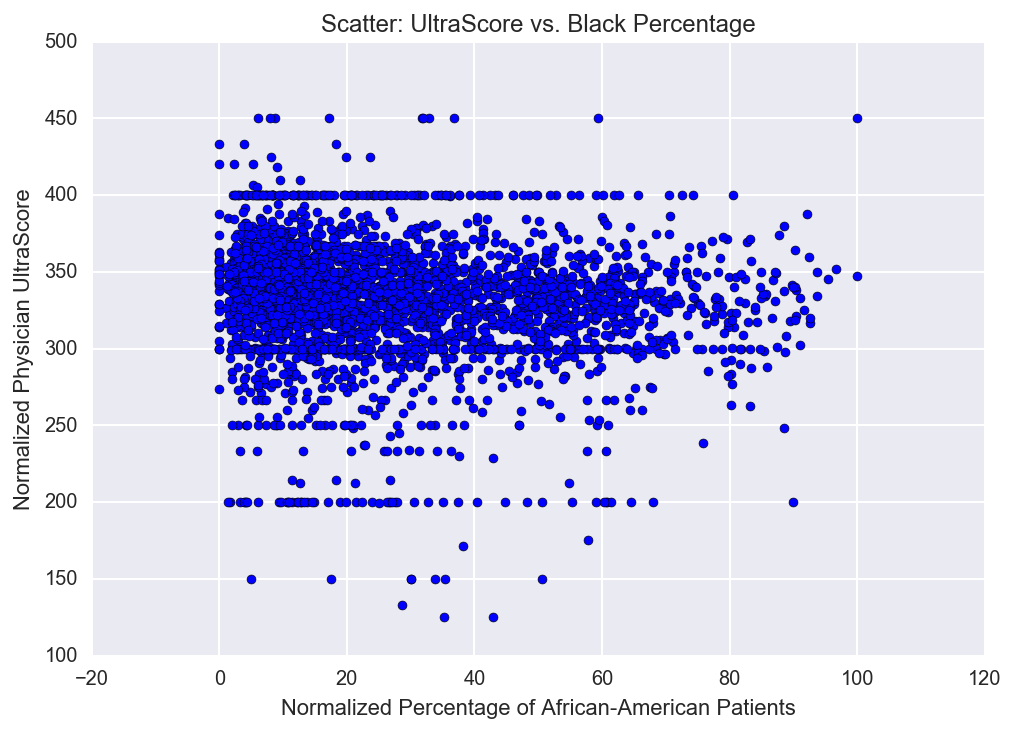

In [26]:
plt.scatter(pNeph.beneficiary_race_black_pct,pNeph.ultra_score)
plt.xlabel('Normalized Percentage of African-American Patients')
plt.ylabel('Normalized Physician UltraScore')
plt.title('Scatter: UltraScore vs. Black Percentage')

In [27]:
# Are there are any factors that stand out for the highest-performing physicians? How about the lowest?

In [28]:
# Take all 219 physicians with scores >= 400 as a group:
highPerformers = pNeph[pNeph.ultra_score>=400]
# Take the lowest-performing 219 physicians as another group:
lowPerformers = pNeph[pNeph.ultra_score<=269]

In [29]:
assert(len(highPerformers)==219)
assert(len(lowPerformers)==219)

In [30]:
# Compare the means of these groups for each factor, vs. the mean of the population

# Easiest to do by normalizing every factor to a standard scale first

In [31]:
# Normalizing Transformer:

class nanCenterScaleTransformer(sk.base.BaseEstimator, sk.base.TransformerMixin):      
    # select given columns from a data frame:    
    def __init__(self):
        self.nanmeans = []
        self.nanstds = []
        
    def fit(self,X,y=None):
        colsX = X.columns
        self.nanmeans = pd.Series(np.zeros(len(colsX)),index=colsX)
        self.nanstds = pd.Series(np.zeros(len(colsX)),index=colsX)
        for cc in X:
            self.nanmeans[cc] = np.nanmean(X[cc])
            self.nanstds[cc] = np.nanstd(X[cc],ddof=1)
    
    def transform(self,X):
        for cc in X:
            X[cc] = (X[cc] - self.nanmeans[cc])/self.nanstds[cc]
        return X

In [32]:
myTx = nanCenterScaleTransformer()
myTx.fit(pNeph)
pNeph = myTx.transform(pNeph)

C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [33]:
# Now every feature of pNeph has been mapped to a unit-scale with mean zero

In [34]:
highPerformers = myTx.transform(highPerformers)
lowPerformers = myTx.transform(lowPerformers)

C:\Users\rek\Desktop\sw\Anaconda\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
pMeansStds = pd.concat([highPerformers.mean(),lowPerformers.mean(),highPerformers.std(),lowPerformers.std()],axis=1)
pMeansStds.columns = ['highMean','lowMean','highStd','lowStd']
pMeansStds

,highMean,lowMean,highStd,lowStd
npi,0.064483,0.059173,1.008475,1.030207
ultra_score,1.892339,-2.731329,0.326507,0.886886
number_of_hcpcs,-0.127420,-0.124639,1.093429,0.962384
total_services_per_bene,0.000162,-0.108205,0.906410,0.767767
total_unique_benes,-0.326799,-0.152004,0.980457,0.997807
total_submitted_chrg_amt_per_bene,-0.083249,-0.177811,0.837478,0.949308
total_medicare_allowed_frac,0.067553,0.066891,0.953919,1.052680
total_medicare_payment_frac,-0.136395,0.173092,1.582990,0.903136
total_medicare_stnd_frac,-0.186705,-0.111935,1.104335,0.973121
number_of_drug_hcpcs,-0.012838,-0.249434,0.953809,0.617934


In [37]:
# Nothing too surprising in the normalized mean and std data.

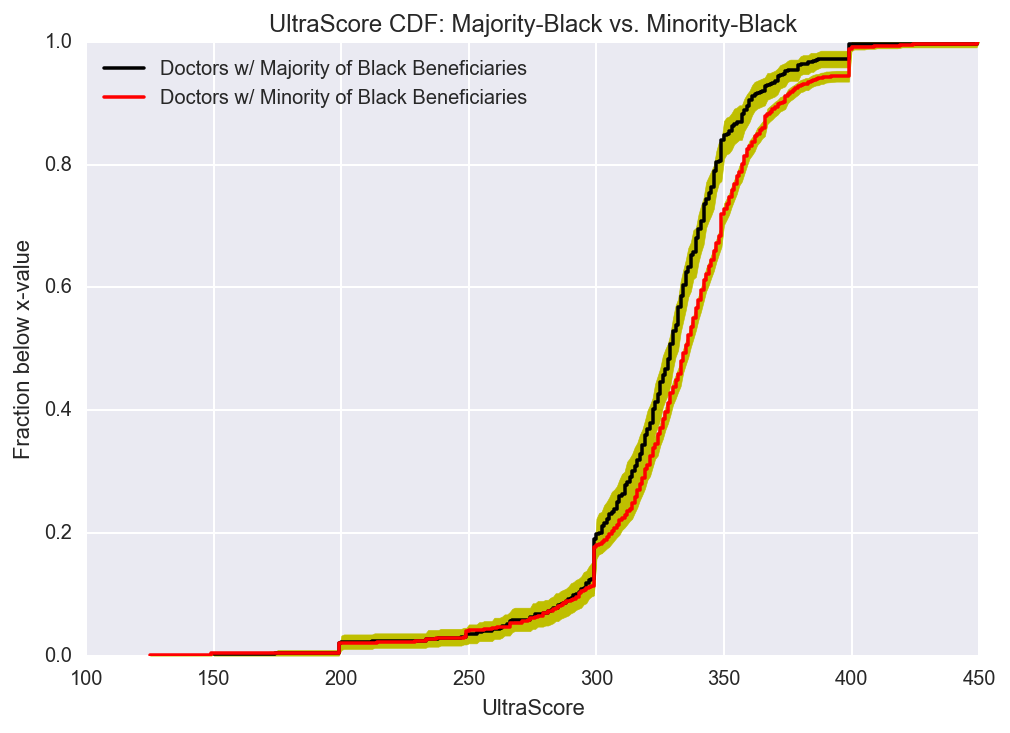

In [38]:
# Compare physicians who see a majority of black beneficiaries vs. those who do not:

x1,y1,y1Lo,y1Hi = xy_cdf(neph.ultra_score[neph.beneficiary_race_black_count/neph.total_unique_benes >= 0.5])
x2,y2,y2Lo,y2Hi = xy_cdf(neph.ultra_score[neph.beneficiary_race_black_count/neph.total_unique_benes < 0.5])
kLine, = plt.step(x1,y1,color='k',label='Doctors w/ Majority of Black Beneficiaries')
rLine, = plt.step(x2,y2,color='r',label='Doctors w/ Minority of Black Beneficiaries')
plt.fill_between(x1,y1Lo,y1Hi,color='y')
plt.fill_between(x2,y2Lo,y2Hi,color='y')
plt.xlabel('UltraScore')
plt.ylabel('Fraction below x-value')
plt.title('UltraScore CDF: Majority-Black vs. Minority-Black')
plt.legend(handles=[kLine,rLine],loc='upper left')
plt.show()